In [1]:
import torch
import json
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from utility import ViltImageSetProcessor
from transformers import BertForSequenceClassification, ViltModel, ViltConfig, ViltForQuestionAnswering
from torch import nn
from copy import deepcopy
from isvqa_data_setup import ISVQA
from torch.utils.data import DataLoader
from engine import max_to_one_hot
from collections import Counter
from torch.optim.lr_scheduler import StepLR
from models import MultiviewViltForQuestionAnsweringBaseline, MultiviewViltModel

In [6]:
import torch
from prettytable import PrettyTable

def count_model_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [12]:
import torch

from torch import nn
from transformers import ViltConfig, ViltModel

encoder = nn.TransformerEncoderLayer(768, 12, dim_feedforward=3072)
vilt_encoder = ViltModel(ViltConfig()).encoder

x = torch.randn(6, 1, 768)
seq = torch.cat([x, torch.randn(6, 8, 768), x, torch.randn(6, 8, 768), x], dim=1)

out_encoder = encoder(seq)
out_vilt = vilt_encoder(seq).last_hidden_state

print(torch.equal(out_encoder[0, 0], out_encoder[0, 9]))
print(torch.equal(out_vilt[0, 0], out_vilt[0, 9]))

False
True


In [2]:
model = MultiviewViltForQuestionAnsweringBaseline(6, 210, 768, True, True, False)
model.model.classifier = nn.Sequential(
            nn.Linear(768, 1536),
            nn.LayerNorm(1536),
            nn.GELU(),
            nn.Linear(1536, 429)
        )
model.load_state_dict(torch.load("/home/nikostheodoridis/Trained Models/2024-07-14 15:01:33/model.pth"))

<All keys matched successfully>

In [3]:
with open("/home/nikostheodoridis/isvqa/answers.json") as f:
    answers = json.load(f)

In [5]:
isvqa = ISVQA("/home/nikostheodoridis/isvqa/val_set.json",
              "/home/nikostheodoridis/nuscenes/samples",
              "/home/nikostheodoridis/isvqa/answers.json",
              device="cpu")

loader = DataLoader(isvqa, 1, shuffle=True)

batch = next(iter(loader))
batch[0]["input_ids"]

tensor([[ 101, 2003, 1996, 3295, 1997, 1996, 3861, 2503, 2030, 2648,  102,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]])

In [278]:
answers[batch[1].argmax().item()]

'seventy-five'

In [6]:
out = model(**batch[0], output_attentions=True)

In [22]:
out.attentions[11].shape

torch.Size([8, 12, 1300, 1300])

In [24]:
out.attentions[11].sum(dim=(1, 2, 3)).shape

torch.Size([8])

In [29]:
img1_attn = out.attentions[11][:, :, :40, 40:90].sum(dim=(1, 2, 3))
img2_attn = out.attentions[11][:, :, :40, 90:140].sum(dim=(1, 2, 3))
img3_attn = out.attentions[11][:, :, :40, 140:190].sum(dim=(1, 2, 3))
img4_attn = out.attentions[11][:, :, :40, 190:240].sum(dim=(1, 2, 3))
img5_attn = out.attentions[11][:, :, :40, 240:290].sum(dim=(1, 2, 3))
img6_attn = out.attentions[11][:, :, :40, 290:].sum(dim=(1, 2, 3))

torch.stack([img1_attn, img2_attn, img3_attn, img4_attn, img5_attn, img6_attn]).permute(1, 0).shape

torch.Size([8, 6])

In [279]:
answers[out.logits.argmax()]

'seventy-five'

In [269]:
from transformers import BertTokenizer

# Load the pre-trained tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example input IDs (these would typically come from encoding a sentence)
input_ids = [101, 2054, 2193, 2064, 2017, 6709, 2006, 1996, 4462, 2311,  102]

# Decode the input IDs back to a string
sentence = tokenizer.decode(input_ids, skip_special_tokens=True)

print("Decoded sentence:", sentence)

Decoded sentence: what number can you identify on the grey building


In [6]:
from transformers import BertModel, BertTokenizer
import torch

# Load pre-trained model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Function to get embeddings
def get_word_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt')
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state
    return embeddings

# Example usage
text = "front-right"
embeddings = get_word_embeddings(text)
print(embeddings.shape)


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

AssertionError: 

In [9]:
print(out.attentions[11][0, 0, :40, :].sum())
print(out.attentions[11][0, :, :40, 250:460].sum())
print(out.attentions[11][0, :, :40, 460:670].sum())
print(out.attentions[11][0, :, :40, 670:880].sum())
print(out.attentions[11][0, :, :40, 880:1090].sum())
print(out.attentions[11][0, :, :40, 1090:1130].sum())

tensor(40., grad_fn=<SumBackward0>)
tensor(69.9275, grad_fn=<SumBackward0>)
tensor(73.5483, grad_fn=<SumBackward0>)
tensor(95.2296, grad_fn=<SumBackward0>)
tensor(105.3054, grad_fn=<SumBackward0>)
tensor(11.3050, grad_fn=<SumBackward0>)


In [15]:
print(out.attentions[11][0, :, :40, 40:80].sum())
print(out.attentions[11][0, :, :40, 250:460].sum())
print(out.attentions[11][0, :, :40, 460:670].sum())
print(out.attentions[11][0, :, :40, 670:880].sum())
print(out.attentions[11][0, :, :40, 880:1090].sum())
print(out.attentions[11][0, :, :40, 1090:1130].sum())

tensor(11.5774, grad_fn=<SumBackward0>)
tensor(64.7524, grad_fn=<SumBackward0>)
tensor(81.3791, grad_fn=<SumBackward0>)
tensor(87.6262, grad_fn=<SumBackward0>)
tensor(74.5127, grad_fn=<SumBackward0>)
tensor(20.2984, grad_fn=<SumBackward0>)


In [289]:
print(out.attentions[11][0, :, :40, :40].sum())

tensor(16.4266, grad_fn=<SumBackward0>)


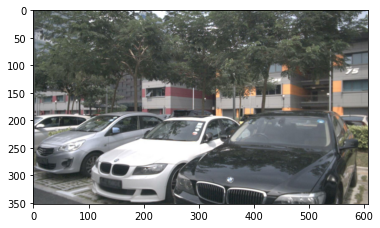

In [281]:
imp_img = (batch[0]["pixel_values"][0, 2].permute(1, 2, 0) + 1) / 2
plt.imshow(imp_img)


In [91]:
imp_img.max()

tensor(1.)

In [56]:
out.attentions[1][0, 0, :10, 40:42]

tensor([[1.6639e-01, 1.0271e-09],
        [1.6666e-01, 3.7068e-13],
        [1.6666e-01, 1.4690e-09],
        [1.6667e-01, 4.0521e-13],
        [1.6667e-01, 9.1355e-17],
        [1.6666e-01, 3.5123e-15],
        [1.6666e-01, 2.7772e-14],
        [1.6666e-01, 7.5157e-13],
        [1.6664e-01, 2.6571e-08],
        [1.6666e-01, 3.6503e-09]], grad_fn=<SliceBackward0>)

In [52]:
torch.sum(out.attentions[1][0, 0, :40, 40])

tensor(6.6663, grad_fn=<SumBackward0>)

In [5]:
attn_scores

NameError: name 'attn_scores' is not defined

In [41]:
question = torch.randn(1, 768)
images = torch.randn(6, 768)
attn = nn.MultiheadAttention(768, 12, batch_first=True)

attn(question, images, images)[0].shape

torch.Size([1, 768])

In [20]:
import json
import random

from copy import deepcopy

with open("/home/nikostheodoridis/nuscenes/v1.0-trainval/sample_data.json") as f:
    set = json.load(f)

In [38]:
t = torch.tensor([[[[0.5, 0.5, 2, 2, 1, 1, 0, 0]]]]).permute(3, 0, 1, 2)

In [157]:
pixel_values = torch.randn(8, 6, 3, 224, 224)

In [158]:
attn_scores = torch.rand(8, 1, 6).softmax(dim=2)

In [159]:
weights = (attn_scores / attn_scores.max(dim=2)[0].unsqueeze(2)).squeeze()

In [160]:
weights

tensor([[0.4555, 1.0000, 0.6897, 0.8853, 0.8412, 0.3991],
        [0.9488, 0.8057, 0.8574, 1.0000, 0.8137, 0.5175],
        [0.7394, 0.7835, 0.6369, 0.9620, 1.0000, 0.5628],
        [0.9099, 0.7829, 1.0000, 0.5576, 0.6096, 0.8529],
        [0.5785, 0.6212, 0.8596, 0.8767, 0.9593, 1.0000],
        [0.5012, 0.9379, 0.5653, 0.3996, 0.6673, 1.0000],
        [0.5426, 0.6238, 1.0000, 0.4984, 0.5130, 0.8265],
        [0.9123, 0.4839, 0.4397, 0.3960, 1.0000, 0.7663]])

In [161]:
noise_factor = 1 - weights
noise_factor

tensor([[0.5445, 0.0000, 0.3103, 0.1147, 0.1588, 0.6009],
        [0.0512, 0.1943, 0.1426, 0.0000, 0.1863, 0.4825],
        [0.2606, 0.2165, 0.3631, 0.0380, 0.0000, 0.4372],
        [0.0901, 0.2171, 0.0000, 0.4424, 0.3904, 0.1471],
        [0.4215, 0.3788, 0.1404, 0.1233, 0.0407, 0.0000],
        [0.4988, 0.0621, 0.4347, 0.6004, 0.3327, 0.0000],
        [0.4574, 0.3762, 0.0000, 0.5016, 0.4870, 0.1735],
        [0.0877, 0.5161, 0.5603, 0.6040, 0.0000, 0.2337]])

In [162]:
noise_factor = noise_factor.unsqueeze(2).unsqueeze(3).unsqueeze(4)
noise = noise_factor * torch.randn_like(pixel_values)
noise.shape

torch.Size([8, 6, 3, 224, 224])

In [165]:
noise_factor[0]

tensor([[[[0.5445]]],


        [[[0.0000]]],


        [[[0.3103]]],


        [[[0.1147]]],


        [[[0.1588]]],


        [[[0.6009]]]])

In [67]:
image = torch.randn(8, 6, 3, 352, 608)

In [76]:
weighted_image = weights * image

In [77]:
weighted_image.shape

torch.Size([8, 6, 3, 352, 608])

In [83]:
weights[2, 5]

tensor([[[0.9333]]])

In [41]:
x = torch.randn(8, 2, 2, 4)

In [27]:
model = Baseline.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

/home/nikostheodoridis/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [28]:
print(model)

ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [ ]:
torch.cuda.is_available()

True

In [29]:
x = torch.randn(8, 6, 3, 352, 608)

In [30]:
type(x)

torch.Tensor

In [31]:
x.shape

torch.Size([8, 6, 3, 352, 608])

In [35]:
x.min()

tensor(-5.3835)

In [ ]:
model.classifier

RobertaClassificationHead(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out_proj): Linear(in_features=768, out_features=2, bias=True)
)

In [ ]:
model.classifier

Linear(in_features=768, out_features=1, bias=True)

In [ ]:
model = MultiviewViltForQuestionAnsweringBaseline(6, 210, 768, True, True, True, 429).to("cuda")

/home/nikostheodoridis/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
from transformers.models.vilt.modeling_vilt import ViltEmbeddings

In [ ]:
import langchain
langchain.__version__

'0.2.11'

In [ ]:
model.classifier

Sequential(
  (0): Linear(in_features=768, out_features=1536, bias=True)
  (1): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
  (2): GELU(approximate='none')
  (3): Linear(in_features=1536, out_features=429, bias=True)
)

In [9]:
isvqa = ISVQA("/home/nikostheodoridis/isvqa/train_set.json",
              "/home/nikostheodoridis/nuscenes/samples",
              "/home/nikostheodoridis/isvqa/answers.json",
              device="cpu")

In [10]:
loader = DataLoader(isvqa, 2, shuffle=False)

In [11]:
batch = next(iter(loader))

In [7]:
out = model(**batch[0]).logits

In [12]:
hidden_states = model(**batch[0], output_hidden_states=True).hidden_states

In [13]:
hidden_states[12].shape

torch.Size([2, 1300, 768])

In [15]:
torch.equal(hidden_states[3][0, 40], hidden_states[3][0, 250])

True

In [11]:
x = torch.randn(8, 6, 210, 768).flatten(1, 2)

In [12]:
x.shape

torch.Size([8, 1260, 768])

In [46]:
cls = nn.Parameter(torch.zeros(1, 6, 1, 768))

In [48]:
cls[:, 0].shape

torch.Size([1, 1, 768])

In [5]:
seq = torch.cat([torch.zeros(6, 1, 768), torch.randn(6, 209, 768), torch.zeros(6, 1, 768), torch.randn(6, 209, 768), torch.zeros(6, 1, 768), torch.randn(6, 209, 768), torch.zeros(6, 1, 768), torch.randn(6, 209, 768), torch.zeros(6, 1, 768), torch.randn(6, 209, 768), torch.zeros(6, 1, 768), torch.randn(6, 209, 768)], dim=1)

In [6]:
big_seq = torch.cat([torch.randn(6, 40, 768), seq], dim=1)

In [7]:
big_seq.shape

torch.Size([6, 1300, 768])

In [6]:
seq.shape

torch.Size([6, 1260, 768])

In [7]:
out = model(inputs_embeds=torch.randn(6, 40, 768), image_embeds=seq)

In [10]:
out.last_hidden_state.shape

torch.Size([6, 1300, 768])

In [8]:
out = model.model.encoder(big_seq)

In [9]:
print(torch.equal(big_seq[0, 40], big_seq[0, 1090]))
print(torch.equal(out.last_hidden_state[0, 40], out.last_hidden_state[0, 1090]))

True
True


In [11]:
encoder = nn.TransformerEncoderLayer(768, 12, dim_feedforward=3072)

In [12]:
out = encoder(big_seq)

In [20]:
count_model_parameters(encoder)

+---------------------------+------------+
|          Modules          | Parameters |
+---------------------------+------------+
|  self_attn.in_proj_weight |  1769472   |
|   self_attn.in_proj_bias  |    2304    |
| self_attn.out_proj.weight |   589824   |
|  self_attn.out_proj.bias  |    768     |
|       linear1.weight      |  2359296   |
|        linear1.bias       |    3072    |
|       linear2.weight      |  2359296   |
|        linear2.bias       |    768     |
|        norm1.weight       |    768     |
|         norm1.bias        |    768     |
|        norm2.weight       |    768     |
|         norm2.bias        |    768     |
+---------------------------+------------+
Total Trainable Params: 7087872


7087872

In [22]:
count_model_parameters(model.model.encoder)

+-------------------------------------------+------------+
|                  Modules                  | Parameters |
+-------------------------------------------+------------+
|  layer.0.attention.attention.query.weight |   589824   |
|   layer.0.attention.attention.query.bias  |    768     |
|   layer.0.attention.attention.key.weight  |   589824   |
|    layer.0.attention.attention.key.bias   |    768     |
|  layer.0.attention.attention.value.weight |   589824   |
|   layer.0.attention.attention.value.bias  |    768     |
|   layer.0.attention.output.dense.weight   |   589824   |
|    layer.0.attention.output.dense.bias    |    768     |
|     layer.0.intermediate.dense.weight     |  2359296   |
|      layer.0.intermediate.dense.bias      |    3072    |
|        layer.0.output.dense.weight        |  2359296   |
|         layer.0.output.dense.bias         |    768     |
|      layer.0.layernorm_before.weight      |    768     |
|       layer.0.layernorm_before.bias       |    768    

85054464

In [13]:
print(torch.equal(big_seq[0, 40], big_seq[0, 1090]))
print(torch.equal(out[0, 40], out[0, 1090]))

True
False


In [14]:
from transformers import ViltModel, ViltConfig

vilt = ViltModel(ViltConfig())

In [19]:
vilt_out = vilt.encoder(big_seq)

: 

In [16]:
print(torch.equal(big_seq[0, 40], big_seq[0, 1090]))
print(torch.equal(vilt_out.last_hidden_state[0, 40], vilt_out.last_hidden_state[0, 1090]))

True
True


In [28]:
out.shape

torch.Size([2, 429])

In [34]:
isvqa[0][0]["pixel_values"].min()

tensor(-1., device='cuda:0')

In [ ]:
loader = DataLoader(isvqa, 4, shuffle=False)
batch = next(iter(loader))

In [ ]:
batch[0].keys()

odict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask'])

In [ ]:
out = model(**batch[0])

In [ ]:
out.shape

torch.Size([4, 429])

In [ ]:
questions = torch.randn(4, 1, 768)
images = torch.randn(4, 6, 768)

attn_scores = torch.randn(4, 1, 6)

In [ ]:
weight = torch.randn()


In [ ]:
with torch.autograd.profiler.profile(use_cuda=True) as prof:
    model = MultiviewViltForQuestionAnsweringBaseline(6, 210, 768, True, True, False).to("cuda")
print(prof.key_averages().table(sort_by="cuda_time_total"))

/home/nikostheodoridis/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


-------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                aten::copy_        46.67%      69.913ms        71.95%     107.799ms     128.638us     110.855ms        68.45%     110.855ms     132.285us           838  
                                   aten::to         0.57%     857.000us        29.40%      44.043ms     205.808us       1.066ms         0.66%      44.273ms     206.883us           214  
                             aten::_to_copy         1.20%       1.795

In [ ]:
loader = DataLoader(isvqa, 1, shuffle=False)

In [ ]:
batch = next(iter(loader))

In [ ]:
out = model(**batch[0])

In [ ]:
out.last_hidden_state.shape

AttributeError: 'torch.Size' object has no attribute 'last_hidden_state'

In [ ]:
questions = torch.randn(1, 768)
images = torch.randn(6, 768)

img_attn = nn.MultiheadAttention(768, 12)

_, attn_scores = img_attn(questions, images, images)

attn_scores[0, 2]

tensor(0.1913, grad_fn=<SelectBackward0>)

In [ ]:
def val_step(model, loader, acc_fn, answ_len):
    """
    A function that validates the model by going through all the mini-batches in the validation dataloader once.
    """
    print("\tValidating...")
    model.eval()
    losses = []  # to save the loss of each mini-batch in order to take their average at the end
    accuracies = []  # to save the accuracy of each mini-batch in order to take their average at the end

    predictions = []
    

    with torch.inference_mode():
        for i, (X, y) in enumerate(loader):
            outputs = model(**X, labels=y)
            loss = outputs.loss
            pred = max_to_one_hot(outputs.logits)
            acc = acc_fn(pred, y, answ_len)

            losses.append(loss.item())
            accuracies.append(acc)

    avg_loss = sum(losses) / len(loader)
    avg_acc = sum(accuracies) / len(loader)
    
    return avg_loss, avg_acc

# Copy

In [ ]:
model = MultiviewViltForQuestionAnswering(6, 210, 768, True, False, False).to("cuda")

/home/nikostheodoridis/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
model.model.classifier = nn.Sequential(
        nn.Linear(768, 1536),
        nn.LayerNorm(1536),
        nn.GELU(),
        nn.Linear(1536, 429)
    ).to("cuda")

In [ ]:
trained_model = deepcopy(model)

In [ ]:
trained_model.load_state_dict(torch.load("/home/nikostheodoridis/Trained Models/2024-07-08 00:07:49/model.pth"))

<All keys matched successfully>

In [ ]:
# for p1, p2 in zip(model.parameters(), trained_model.parameters()):
#     assert torch.equal(p1, p2)

In [ ]:
val_set = ISVQA(qa_path="/home/nikostheodoridis/isvqa/val_set.json",
                nuscenes_path="/home/nikostheodoridis/nuscenes/samples",
                answers_path="/home/nikostheodoridis/isvqa/answers.json")

In [ ]:
val_loader = DataLoader(val_set, batch_size=6, shuffle=False)

In [ ]:
# targets = []
# untrained_predictions = []
# trained_predictions = []

# model.eval()
# trained_model.eval()
# for i in range(2576):
#     inputs, target = val_set[i]

#     targets.append(target)

#     with torch.inference_mode():
        


In [ ]:
def accuracy(predictions: torch.Tensor, targets: torch.Tensor, answers_len: int) -> float:
    cnt = torch.eq(torch.eq(predictions, targets).sum(dim=1), answers_len).sum()
    return cnt.item() / len(predictions)

In [ ]:
untrained_loss, untrained_acc = val_step(model, val_loader, accuracy, 429)

	Validating...


In [ ]:
trained_loss, trained_acc = val_step(trained_model, val_loader, accuracy, 429)

	Validating...


In [ ]:
print(untrained_loss)
print(untrained_acc)

303.8099614342978
0.0011627906976744186


In [ ]:
print(trained_loss)
print(trained_acc)

2.5099486532945967
0.6003875968992246


In [ ]:
with open("/home/nikostheodoridis/isvqa/answers_counter.json") as f:
    answers_cnt = json.load(f)

In [ ]:
Counter(answers_cnt)

Counter({'yes': 13564,
         'no': 3734,
         'one': 3663,
         'white': 2893,
         'two': 2544,
         'red': 1205,
         'black': 1046,
         'blue': 1025,
         'three': 986,
         'green': 968,
         'yellow': 930,
         'orange': 782,
         'four': 529,
         'night': 464,
         'rainy': 434,
         'gray': 365,
         'black and white': 345,
         'silver': 287,
         'zero': 254,
         'five': 218,
         'orange and white': 178,
         'six': 156,
         'left': 151,
         'none': 147,
         'ahead': 147,
         'right': 141,
         'fedex': 136,
         'brown': 134,
         'cloudy': 129,
         'slow': 119,
         'ups': 114,
         'bus': 112,
         'raining': 111,
         'wet': 111,
         'sunny': 107,
         'ryder': 95,
         'urban': 93,
         'twenty-three': 92,
         'stop': 89,
         'day': 77,
         'hump': 69,
         'brick': 69,
         'red and white': 57,

In [ ]:
# Start
import json
import random
train_path = "/home/nikostheodoridis/nuscenes-qa/train_set.json"

val_path = "/home/nikostheodoridis/nuscenes-qa/val_set.json"

test_path = "/home/nikostheodoridis/nuscenes-qa/test_set.json"
with open(train_path) as f:
    train_data = json.load(f)

with open(val_path) as f:
    val_data = json.load(f)

with open(test_path) as f:
    test_data = json.load(f)

for data in train_data:
    if data in test_data:
        print("False")
        break
else:
    print("True")

True
